2025-07-05 19:52:37.550231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751745157.767004      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751745157.830146      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 12429 images belonging to 5 classes.
Found 3111 images belonging to 5 classes.
Found 12429 images belonging to 5 classes.
Found 12429 training images belonging to 5 classes.
Found 3111 validation images belonging to 5 classes.
=== PIPELINE STEP 1: FINE-TUNING ResNet50 ===


I0000 00:00:1751745184.277727      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751745184.278461      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1751745243.224981     117 service.cc:148] XLA service 0x799b94004740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751745243.225800     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751745243.225823     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751745248.238752     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751745277.151753     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.6255 - loss: 1.0568 - val_accuracy: 0.7509 - val_loss: 1.1647 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7863 - loss: 0.6252 - val_accuracy: 0.8239 - val_loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8230 - loss: 0.5272 - val_accuracy: 0.8586 - val_loss: 0.4766 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8452 - loss: 0.4705 - val_accuracy: 0.8518 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.8599 - loss: 0.4200 - val_accuracy: 0.8586 - val_loss: 0.5066 - learning_rate: 1.0000e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8694 - loss: 0.3897 - val_accuracy: 0.8473 - val_loss: 0.5177 - learning_rate: 1.0000e-04
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.88

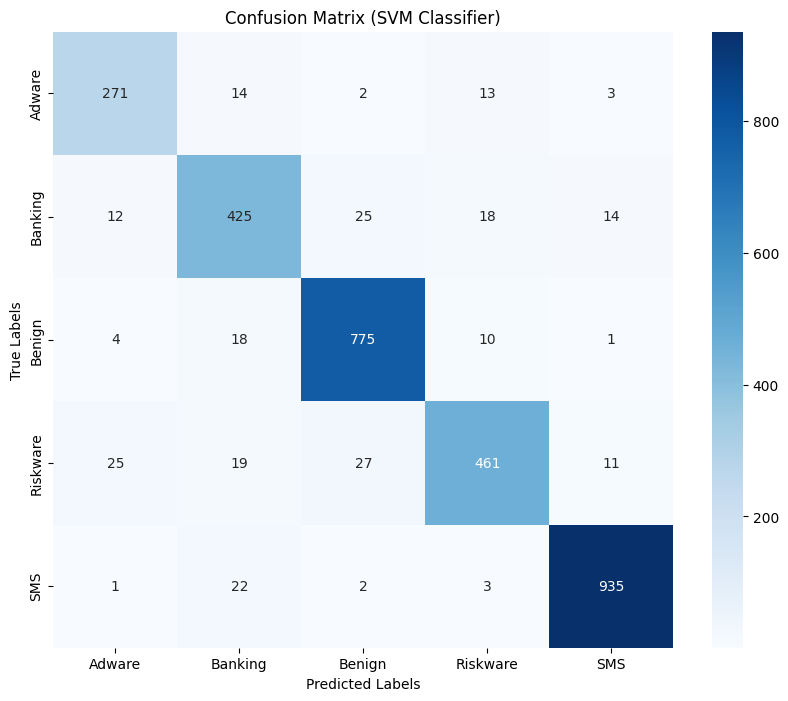

In [1]:
# -*- coding: utf-8 -*-
"""
Implements the hybrid malware detection framework using ResNet50.
Model: ResNet50 (Feature Extractor) + SVM (Classifier)
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math

# --- SỬ DỤNG ResNet50 ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==============================================================================
# 1. CONFIGURATION AND PATHS
# ==============================================================================
base_dir = "/kaggle/input/cic-apk/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "val")
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Dataset directory not found at: {base_dir}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 30

# ==============================================================================
# 2. DATA GENERATORS
# ==============================================================================
# QUAN TRỌNG: Sử dụng preprocess_input của ResNet
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,  # Xoay ngẫu nhiên mạnh hơn
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.5,
    brightness_range=[0.2, 1.8]  # Thay đổi độ sáng mạnh
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
train_predict_generator = test_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Found {train_generator.samples} training images belonging to {num_classes} classes.")
print(f"Found {test_generator.samples} validation images belonging to {num_classes} classes.")

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(test_generator.samples / BATCH_SIZE)
train_predict_steps = math.ceil(train_predict_generator.samples / BATCH_SIZE)

# ==============================================================================
# 3. DEEP LEARNING MODEL DEFINITION AND TRAINING
# ==============================================================================
def create_model_for_finetuning(input_shape, num_classes):
    """
    Constructs a ResNet50-based model with a new classifier head.
    """
    # Load the ResNet50 base model.
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="classifier")(x)
    model = models.Model(inputs, outputs)
    return model

def train_dl_model(model, train_gen, test_gen):
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    history = model.fit(
        train_gen, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
        validation_data=test_gen, validation_steps=validation_steps, callbacks=[early_stopping, reduce_lr])
    return history, model

# ==============================================================================
# 4. FEATURE EXTRACTION AND SVM CLASSIFICATION
# ==============================================================================
def extract_features(model, data_generator, steps):
    print(f"Extracting features from {data_generator.n} samples...")
    features = model.predict(data_generator, steps=steps, verbose=1)
    return features

def evaluate_svm_model(X_train, y_train, X_test, y_test, class_names):
    print("\n--- Training SVM Classifier ---")
    svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42, verbose=True)
    svm_classifier.fit(X_train, y_train)
    print("\n--- Evaluating SVM Classifier Performance ---")
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nFinal SVM Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report (SVM):")
    print(classification_report(y_test, y_pred, target_names=class_names))
    c_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (SVM Classifier)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# ==============================================================================
# 5. MAIN EXECUTION PIPELINE
# ==============================================================================
print("=== PIPELINE STEP 1: FINE-TUNING ResNet50 ===")
finetuning_model = create_model_for_finetuning(input_shape=(*IMG_SIZE, 3), num_classes=num_classes)
history, trained_model = train_dl_model(finetuning_model, train_generator, test_generator)
print("Fine-tuning complete.")

print("\n=== PIPELINE STEP 2: EXTRACTING DEEP FEATURES ===")
feature_extractor_model = models.Model(
    inputs=trained_model.input, outputs=trained_model.get_layer("avg_pool").output)

X_train_features = extract_features(feature_extractor_model, train_predict_generator, train_predict_steps)
X_test_features = extract_features(feature_extractor_model, test_generator, validation_steps)
y_train_labels = train_predict_generator.classes
y_test_labels = test_generator.classes

print(f"\nShape of training features: {X_train_features.shape}")
print(f"Shape of testing features: {X_test_features.shape}")

# === STEP 3: Train and Evaluate the SVM Classifier ===
evaluate_svm_model(X_train_features, y_train_labels, X_test_features, y_test_labels, class_names)